
# ⚡ Optimized XGBoost Pipeline

This notebook trains an optimized `XGBClassifier` using:

- ✅ Cleaned feature processing (`dataInfo.ipynb`)
- ✅ SMOTE for class imbalance
- ✅ Optuna for hyperparameter tuning
- ✅ Stratified K-Fold cross-validation
- ✅ ROC AUC, F1, Accuracy, Precision/Recall evaluation


In [ ]:
from IPython.display import Markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import matthews_corrcoef, average_precision_score, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import os
original_dir = os.getcwd()
if os.path.basename(original_dir) == "SupervisedModels":
    os.chdir(os.path.dirname(original_dir))


In [ ]:
if 'ShowOutput' in locals() or 'ShowOutput' in globals():
    ShowOutput = ShowOutput
else:
    ShowOutput = False
# Load and clean data
%run dataInfo.ipynb

score_cols = [f"A{i}_Score" for i in range(1, 11)]
train_df['total_score'] = train_df[score_cols].sum(axis=1)
test_df['total_score'] = test_df[score_cols].sum(axis=1)

# Normalize the total score
train_df['score_ratio'] = train_df['total_score'] / 10
test_df['score_ratio'] = test_df['total_score'] / 10

# Add interaction features
train_df['gender_result'] = train_df['gender'] * train_df['result']
train_df['age_score_ratio'] = train_df['age'] * train_df['score_ratio']
train_df['score_autism'] = train_df['total_score'] * train_df['autism']
train_df['age_jaundice'] = train_df['age'] * train_df['jaundice']
train_df['autism_result'] = train_df['autism'] * train_df['result']
train_df['gender_total_score'] = train_df['gender'] * train_df['total_score']

test_df['gender_result'] = test_df['gender'] * test_df['result']
test_df['age_score_ratio'] = test_df['age'] * test_df['score_ratio']
test_df['score_autism'] = test_df['total_score'] * test_df['autism']
test_df['age_jaundice'] = test_df['age'] * test_df['jaundice']
test_df['autism_result'] = test_df['autism'] * test_df['result']
test_df['gender_total_score'] = test_df['gender'] * test_df['total_score']

# Clean via helper
cleanTrain, cleanTest = train_df, test_df
X = cleanTrain.drop(columns=["Class/ASD"])
y = cleanTrain["Class/ASD"]

X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [ ]:

def tune_xgboost_with_cv(X, y, n_trials=30):
    smote = SMOTE(random_state=42)
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_jobs': 1,
            'tree_method': 'exact'
        }

        f1_scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            X_train = imputer.fit_transform(X_train)
            X_val = imputer.transform(X_val)
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            model = XGBClassifier(**params)
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred))

        return np.mean(f1_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    if(ShowOutput):
        print("Best hyperparameters:", study.best_params)
    return study.best_params


In [13]:
best_params = tune_xgboost_with_cv(X_train_main, y_train_main, n_trials=40)

# Final preprocessing and model training
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X_train_main)
X_scaled = scaler.fit_transform(X_imputed)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y_train_main)

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_resampled, y_resampled)


Best hyperparameters: {'n_estimators': 128, 'max_depth': 7, 'learning_rate': 0.062384953399603, 'gamma': 2.39172710647358, 'subsample': 0.5713592258343287, 'colsample_bytree': 0.9457001619191968, 'scale_pos_weight': 8.213166636581718}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9457001619191968, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=2.39172710647358, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.062384953399603,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=128, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Step 1: Copy test
X_test = cleanTest.copy()

# Step 2: Ensure all columns in training exist in test
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # or np.nan if imputer is used

# Step 3: Reorder to match training
X_test = X_test[X.columns]

imputer.fit(X_test)
scaler.fit(X_test)

# Step 4: Preprocess
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Step 5: Predict
test_predictions = xgb_model.predict(X_test)
test_probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Step 6: Store in test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Class/ASD'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities

F1 Score: 0.8514851485148515
ROC AUC: 0.9889561431453754
Accuracy: 0.9296875
Precision: 0.7413793103448276
Recall: 1.0


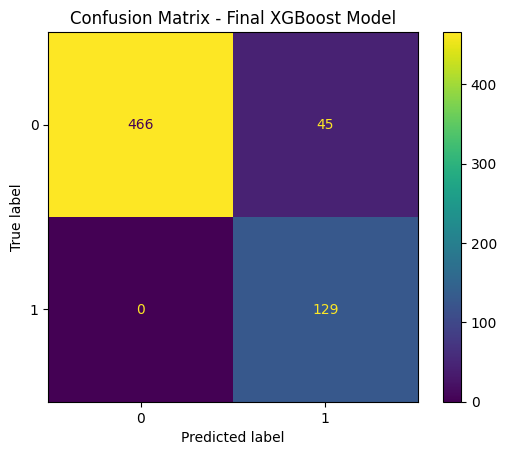

In [ ]:

y_proba = xgb_model.predict_proba(X_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

final_roc_auc = roc_auc_score(y_train_main, y_pred)
final_pr_auc = average_precision_score(y_train_main, y_pred)
final_f1 = f1_score(y_train_main, y_pred)
final_mcc = matthews_corrcoef(y_train_main, y_pred)
accuracy = accuracy_score(y_train_main, y_pred)

if(ShowOutput):
    # print("F1 Score:", f1_score(y_train_main, y_pred))
    # print("ROC AUC:", roc_auc_score(y_train_main, y_proba))
    # print("Accuracy:", accuracy_score(y_train_main, y_pred))
    # print("Precision:", precision_score(y_train_main, y_pred))
    # print("Recall:", recall_score(y_train_main, y_pred))
    
    ConfusionMatrixDisplay.from_predictions(y_train_main, y_pred)
    plt.title("Confusion Matrix - Final XGBoost Model")
    plt.show()
    df_metrics = pd.DataFrame({
        "Metric": ["ROC AUC", "PR AUC", "F1 Score", "Matthews Corrcoef", "Accuracy"],
        "Value": [final_roc_auc, final_pr_auc, final_f1, final_mcc, accuracy]
    })

    df_metrics["Value"] = df_metrics["Value"].map("{:.4f}".format)

    display(df_metrics)
